<a href="https://colab.research.google.com/github/HARASEON/ML_class/blob/main/ML_HW3_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Caution!

Before you run this code, please read it first because there is random function.

### It works well! please run severl time!

-  This code works depending on the random value which makes NaN value sometimes and this makes error.

### You have to run several time when this code is not working because of the random value including NaN.

I could not find the other way to solve. I'm sorry 

{'phi': 0.800455413471236, 'mu0': array([-1.8682944 ,  0.45409721]), 'mu1': array([ 0.4958126 , -0.46823987]), 'sigma0': array([[3.99816255, 1.03178441],
       [1.03178441, 0.35574863]]), 'sigma1': array([[0.67658882, 0.09845034],
       [0.09845034, 1.08259809]])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


	phi: 0.6485485654559756
	mu_0: [13.32032595 17.82082261]
	mu_1: [10.10721379 16.09005126]
	sigma_0:            x1         x2
x1  17.624809 -10.145457
x2 -10.145457   7.806049
	sigma_1:            x1         x2
x1  11.874704   7.573745
x2   7.573745  16.109862
total steps:  39


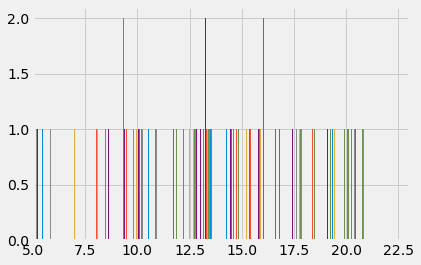

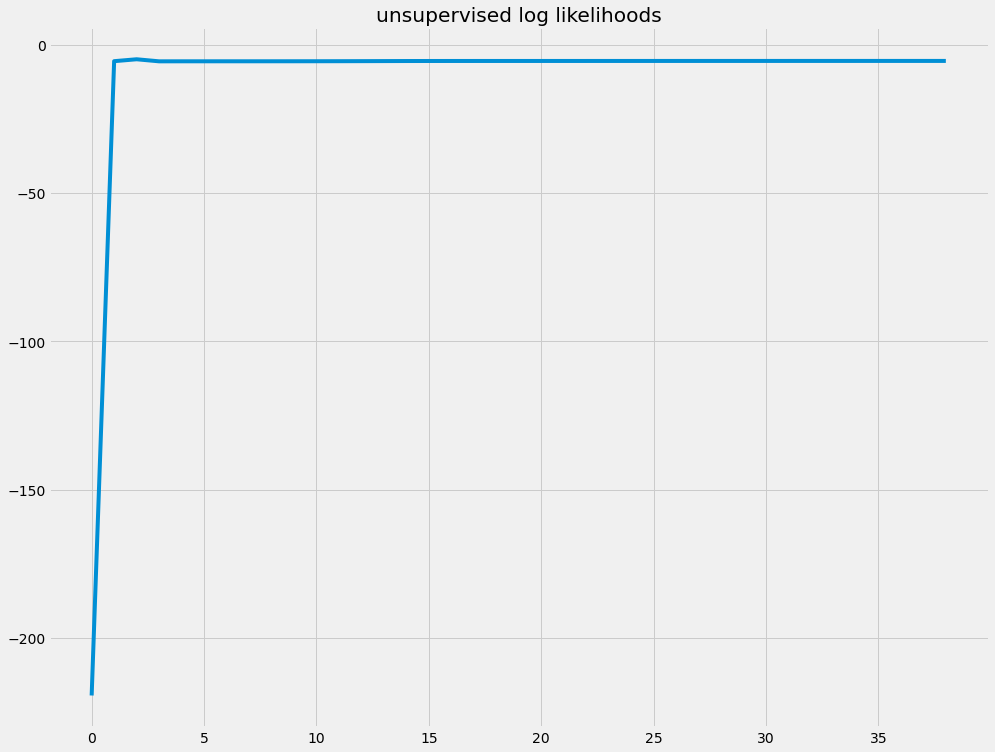

2


<Figure size 864x576 with 0 Axes>

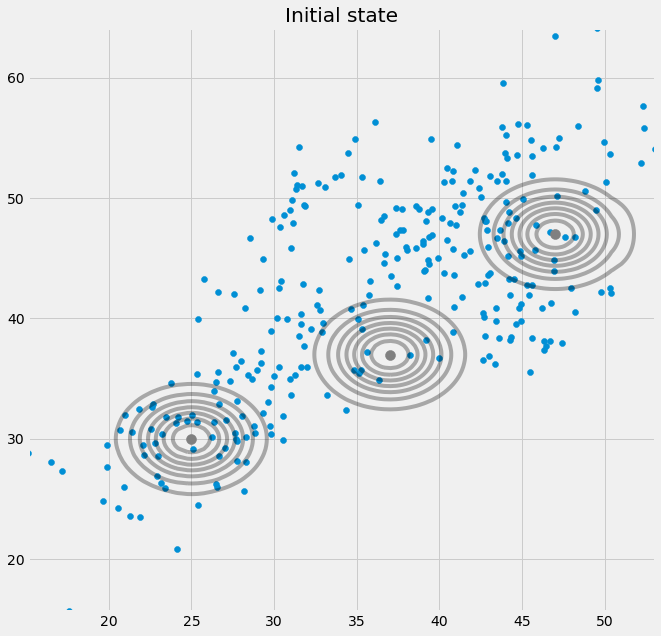

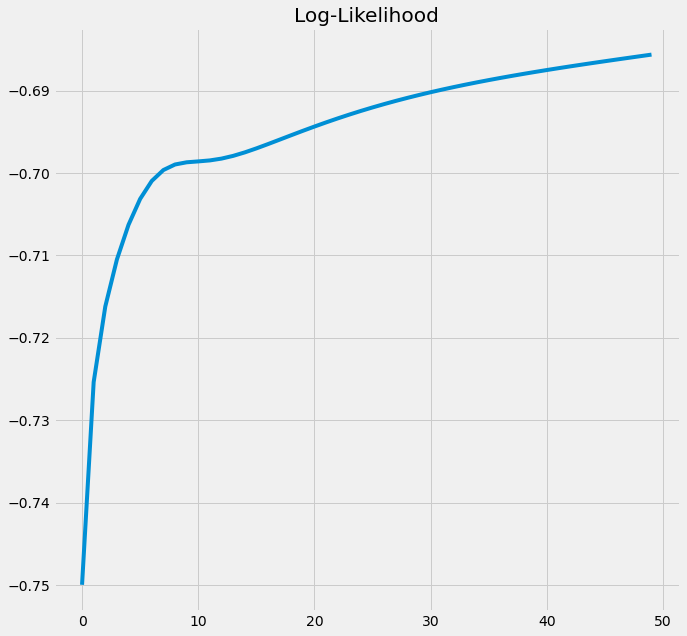

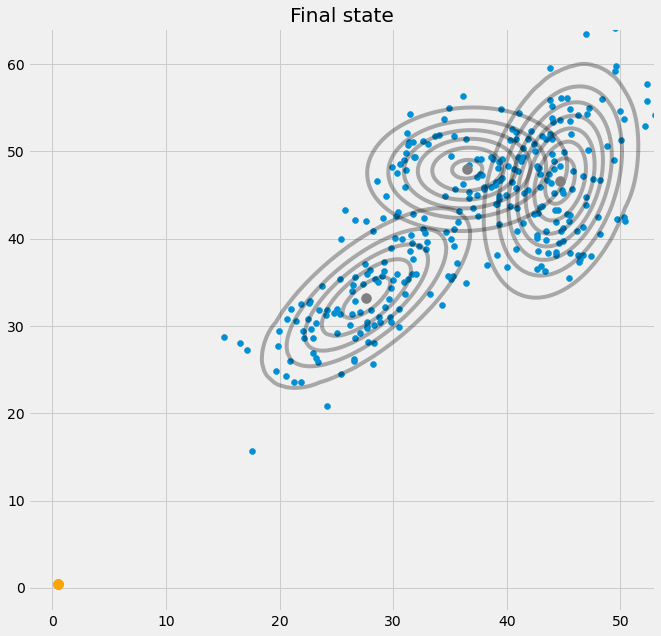

[5.841566045588501e-39, 2.9375263877696793e-32, 1.0]

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import warnings
import sys
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import StandardScaler
from plotnine import *
# %matplotlib inline

# Please input your txt file path in right below.
data_unlabeled = pd.read_table('/content/drive/My Drive/exam_for_ML/GMM-data.txt', sep=' ', header = None)
data_unlabeled.columns = ["x1","x2"] # label names are x1 and x2.
features = ["x1","x2"]
X = data_unlabeled[features]
z = StandardScaler()
X[features] = z.fit_transform(X)

data_unlabeled

# testing
EM = GaussianMixture(n_components=3)
EM.fit(X)
cluster = EM.predict(X)
cluster

cluster_p = EM.predict_proba(X)
np.shape(cluster_p)

X['cluster'] = cluster
ggplot(X, aes(x="x1",y ="x2", color = 'cluster')) + geom_point()

""" Coding without Open library"""

# Data exploring
plt.hist(data_unlabeled, histtype = 'bar')
plt.xlim(5, 23)
plt.figure(figsize =(15,12))

## GMM(Gausian Mixture Model)
# Step 1 initializing all the unknown parameters.

def get_random_psd(n):
    '''
    Initializing parameters which is positive semi-definite.
    '''
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

def e_step(x, params):
    '''
    Expectation Step
    Calculate 
    - the heuristic of the Q(y = x1|x) and Q(y= x2|x) for every data point
    - average log-likelihoods that will be maximized in the M step
    '''
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"], allow_singular=True).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"], allow_singular=True).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"], allow_singular=True).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"], allow_singular=True).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

def m_step(x, params):
    '''
    Maximization Step
    Caution! It can be local maximum
    '''
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params


# Running EM algorithm until the average log-likelihood converges.
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(data_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"            % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(data_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

random_params = initialize_random_params()
print(random_params)
unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(data_unlabeled, random_params)
print("total steps: ", len(unsupervised_loglikelihoods))

plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")
plt.show()

fig = plt.figure(figsize = (12, 8))

np.shape(data_unlabeled)
np.shape(cluster)

""" EM algorithm"""

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import norm, multivariate_normal

X=data_unlabeled # (300,2)
X = np.dot(X, np.random.RandomState(0).randn(2, 2))
Y=cluster # (300,)

# 2D case

class EM:

    def __init__(self, X, number_of_sources, iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None

    """Define a function which runs for iterations, iterations"""

    def run(self):
        self.reg_cov = 1e-6 * np.identity(len(self.X[0]))
        x, y = np.meshgrid(np.sort(self.X[:, 0]), np.sort(self.X[:, 1]))
        self.XY = np.array([x.flatten(), y.flatten()]).T
        print(len(self.X[0]))

        """ 1. Set the initial mu, covariance and pi values"""
        self.mu = np.random.randint(min(self.X[:, 0]), max(self.X[:, 0]), size=(self.number_of_sources, len(
            self.X[0])))  # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
        self.cov = np.zeros((self.number_of_sources, len(X[0]), len(X[0])))  # We need a nxmxm covariance matrix for each source since we have m features -> We create symmetric covariance matrices with ones on the digonal
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim], 5)

        self.pi = np.ones(self.number_of_sources) / self.number_of_sources  # "Fractions"
        log_likelihoods = []  # In this list we store the log likehoods per iteration and plot them in the end to check if we have converged

        """Plot the initial state"""
        fig = plt.figure(figsize=(10, 10))
        ax0 = fig.add_subplot(111)
        ax0.scatter(self.X[:, 0], self.X[:, 1])
        ax0.set_title('Initial state')
        for m, c in zip(self.mu, self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m, cov=c)
            ax0.contour(np.sort(self.X[:, 0]), np.sort(self.X[:, 1]),
                        multi_normal.pdf(self.XY).reshape(len(self.X), len(self.X)), colors='black', alpha=0.3)
            ax0.scatter(m[0], m[1], c='grey', zorder=10, s=100)

        for i in range(self.iterations):

            """E Step"""
            r_ic = np.zeros((len(self.X), len(self.cov)))

            for m, co, p, r in zip(self.mu, self.cov, self.pi, range(len(r_ic[0]))):
                co += self.reg_cov
                mn = multivariate_normal(mean=m, cov=co)
                r_ic[:, r] = p * mn.pdf(self.X) / np.sum(
                    [pi_c * multivariate_normal(mean=mu_c, cov=cov_c).pdf(X) for pi_c, mu_c, cov_c in
                     zip(self.pi, self.mu, self.cov + self.reg_cov)], axis=0)

            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c -> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:, c], axis=0)
                mu_c = (1 / m_c) * np.sum(self.X * r_ic[:, c].reshape(len(self.X), 1), axis=0)
                self.mu.append(mu_c)

                # Calculate the covariance matrix per source based on the new mean
                self.cov.append(((1 / m_c) * np.dot((np.array(r_ic[:, c]).reshape(len(self.X), 1) * (self.X - mu_c)).T,
                                                    (self.X - mu_c))) + self.reg_cov)
                # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source
                self.pi.append(m_c / np.sum(r_ic))  # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know
                # That the columns of each row of r_ic adds up to 1.
                # Since we add up all elements, we sum up all columns per row which gives 1 and then all rows which gives then the number of instances (rows)
                # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                # The elements in pi_new must add up to 1

            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k * multivariate_normal(self.mu[i], self.cov[j]).pdf(X) for k, i, j in
                                                  zip(self.pi, range(len(self.mu)), range(len(self.cov)))])))

            """
            This process of E step followed by a M step is now iterated a number of n times.
            In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on.
            """

        fig2 = plt.figure(figsize=(10, 10))
        ax1 = fig2.add_subplot(111)
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0, self.iterations, 1), log_likelihoods)
        plt.show()

    """Predict the membership of an unseen, new datapoint"""

    def predict(self, Y):
        # PLot the point onto the fittet gaussians
        fig3 = plt.figure(figsize=(10, 10))
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:, 0], self.X[:, 1])
        for m, c in zip(self.mu, self.cov):
            multi_normal = multivariate_normal(mean=m, cov=c)
            ax2.contour(np.sort(self.X[:, 0]), np.sort(self.X[:, 1]),
                        multi_normal.pdf(self.XY).reshape(len(self.X), len(self.X)), colors='black', alpha=0.3)
            ax2.scatter(m[0], m[1], c='grey', zorder=10, s=100)
            ax2.set_title('Final state')
            for y in Y:
                ax2.scatter(y[0], y[1], c='orange', zorder=10, s=100)
        prediction = []
        for m, c in zip(self.mu, self.cov):
            prediction.append(multivariate_normal(mean=m, cov=c).pdf(Y) / np.sum(
                [multivariate_normal(mean=mean, cov=cov).pdf(Y) for mean, cov in zip(self.mu, self.cov)]))
        plt.show() # Now, you can compare the initial state and final state. Depending on the mu, cov and pi, the classification is different and final state is perfect fit because it comes through EM algorithm.
        return prediction
         
    
    
EM = EM(X,3,50)     
EM.run()
EM.predict([[0.5,0.5]]) # General prediction of pi